In [95]:
import numpy as np
from scipy.integrate import odeint
import importlib.util
import scipy.stats
import matplotlib.pyplot as plt
import copy
import sys
import os
import pandas as pd




# Manually specify the path to the directory containing plot_utility.py
util_path = '/home/austin/Drone_AFRL/util'

# Add the directory to the Python path
sys.path.append(util_path)

# import the function we want from that file
from plot_utility import plot_tme

# Define the file path
file_path = '/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py'
file_path_ekf = '/home/austin/Drone_AFRL/ekf.py'
file_path_trajectory = '/home/austin/Drone_AFRL/trajectory_maker.py'

# Define the module name
module_name = 'MPC_DRONE'
EKF_Module = 'ekf'
trajectory_module = 'trajectory_maker'

# Load the module
spec = importlib.util.spec_from_file_location(module_name, file_path)
MPCD = importlib.util.module_from_spec(spec)
sys.modules[module_name] = MPCD
spec.loader.exec_module(MPCD)

# Load the EKF module
spec_ekf = importlib.util.spec_from_file_location(EKF_Module, file_path_ekf)
EKF = importlib.util.module_from_spec(spec_ekf)
sys.modules[EKF_Module] = EKF
spec_ekf.loader.exec_module(EKF)

# Load the trajectory module
spec_trajectory = importlib.util.spec_from_file_location(trajectory_module, file_path_trajectory)
trajectory = importlib.util.module_from_spec(spec_trajectory)
sys.modules[trajectory_module] = trajectory
spec_trajectory.loader.exec_module(trajectory)


MPC_DRONE_WITH_WIND.py imported successfully!
ekf.py loaded successfully


# Setting up params

In [96]:
TIME=4
dt=0.1
T_length=int(TIME/dt)
t = np.linspace(0,T_length*dt,T_length)

m  = 1.0 # [kg] mass
l  = 0.4 # [m] length
Ix = 1.0 # [kg*m^2] moment of inertia
Iy = 1.0 # [kg*m^2] moment of inertia
Iz = 1.0 # [kg*m^2] moment of inertia
Jr = 1.0 # [kg*m^2] polar moment of inertia
b  = 1.0 # thrust coefficient
d  = 1.0 # drag coefficient
Dl = 2.0 # drag coefficient from ground speed
Dr = 2.0 # drag coefficient from rotation speed

########################################################################################
#################### Real Drone Parameters #############################################
########################################################################################
Real_m   = 0.086  # [kg] mass
Real_M   = 2.529  # [kg] mass
Real_mM  = Real_M+4*Real_m  # [kg] mass (total=2.529+4*0.086=2.897)
Real_l   = 0.2032 # [m] length
Real_r   = 0.1778 # [m] average body radius
Real_Ix  = 2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Iy  = 2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Iz  = 2*(Real_M*Real_r**2)/5 + 4*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Jr  = 2*(Real_M*Real_r**2)/5 # [kg*m^2] polar moment of inertia ### FAKE VALUE
Real_b   = 1.8311 # thrust coefficient
Real_d   = 0.01 # drag coefficient
Real_Dl  = 0.1 # drag coefficient from ground speed plus air speed
Real_Dr  = 0.1 # drag coefficient from rotation speed

print('Real Drone Parameters:')
print('Real_m:       ', Real_m)
print('Real_M:       ', Real_M)
print('Real_M_total: ', Real_mM)
print('Real_l:       ', Real_l)
print('Real_r:       ', Real_r)
print('Real_Ix:      ', Real_Ix)
print('Real_Iy:      ', Real_Iy)
print('Real_Iz:      ', Real_Iz)
print('Real_Jr:      ', Real_Jr)
print('Real_b:       ', Real_b)
print('Real_d:       ', Real_d)
print('Real_Dl:      ', Real_Dl)
print('Real_Dr:      ', Real_Dr)


# params = [m,l,Ix,Iy,Iz,Jr,b,d,Dl,Dr]
params = [Real_mM,Real_l,Real_Ix,Real_Iy,Real_Iz,Real_Jr,Real_b,Real_d,Real_Dl,Real_Dr]
g  = 9.81 # m/s^2

Real Drone Parameters:
Real_m:        0.086
Real_M:        2.529
Real_M_total:  2.8729999999999998
Real_l:        0.2032
Real_r:        0.1778
Real_Ix:       0.039081470224
Real_Iy:       0.039081470224
Real_Iz:       0.046183391504
Real_Jr:       0.031979548944
Real_b:        1.8311
Real_d:        0.01
Real_Dl:       0.1
Real_Dr:       0.1


Keys for constant velocity trajectory: dict_keys(['Vx', 'Vy', 'Vz', 'Wx', 'Wy', 'Wz', 'Z', 'T', 'PSI'])
Keys for acceleration trajectory: dict_keys(['Vx', 'Vy', 'Vz', 'Wx', 'Wy', 'Wz', 'Z', 'T', 'PSI'])
Keys for turning trajectory: dict_keys(['Vx', 'Vy', 'Vz', 'Wx', 'Wy', 'Wz', 'Z', 'T', 'PSI'])


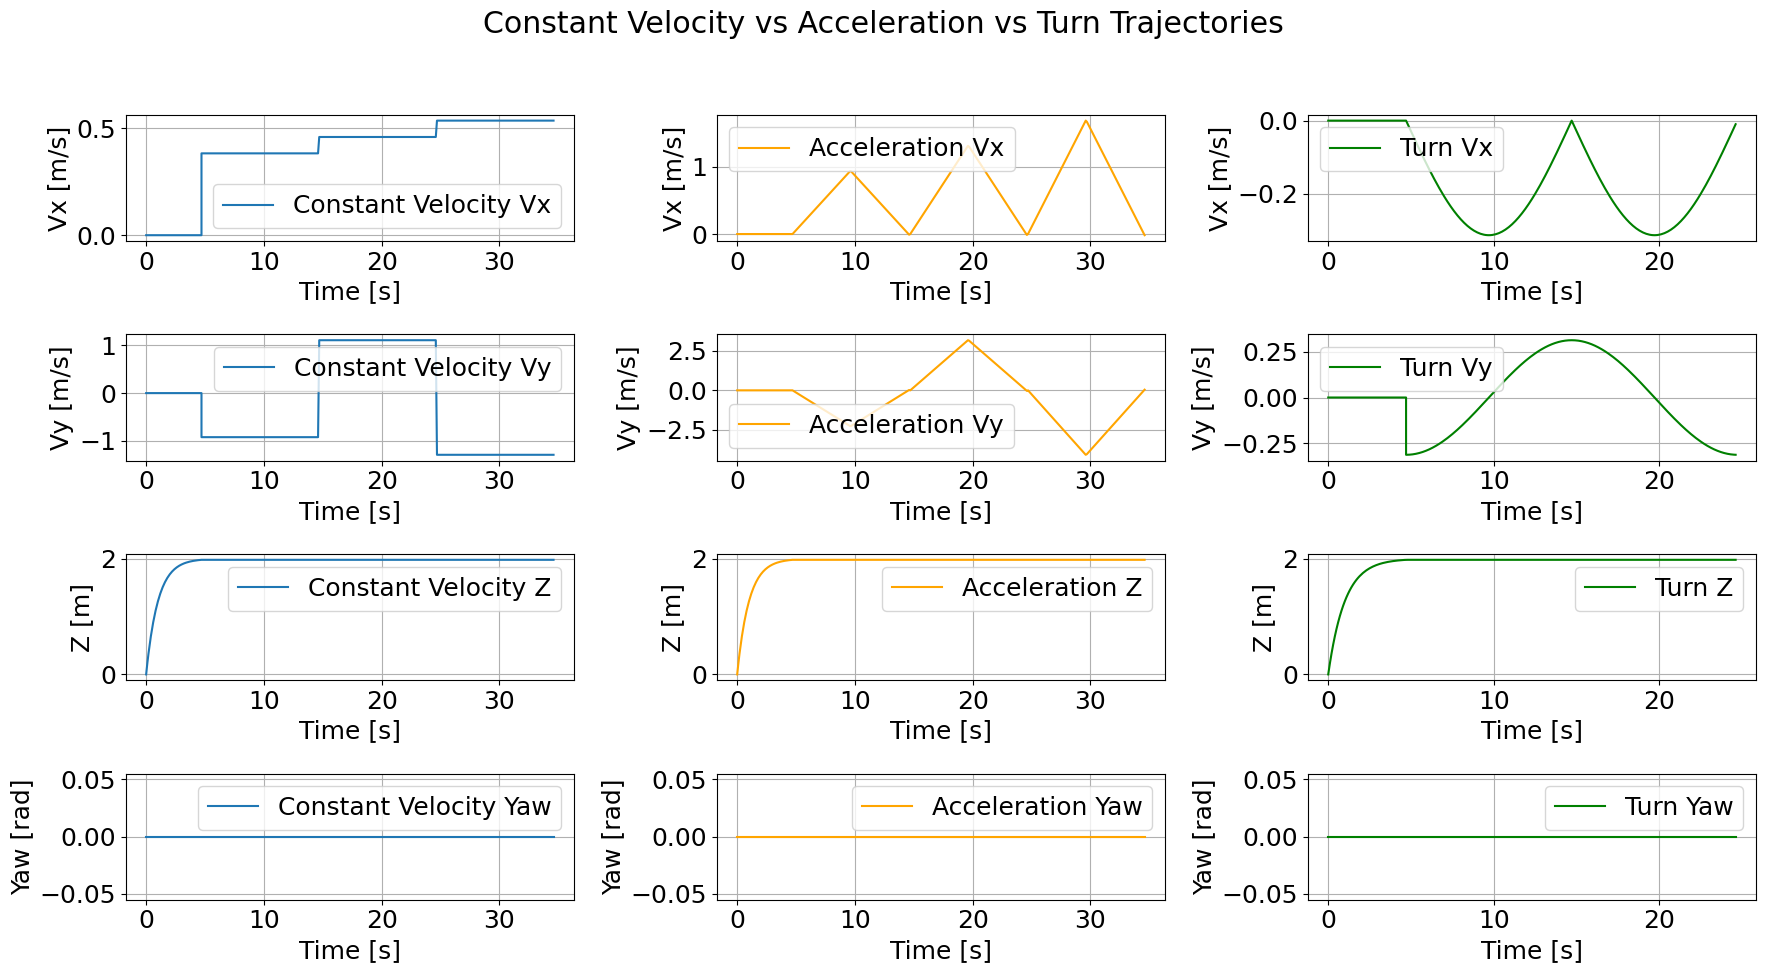

In [98]:
# Create an instance of TrajectoryGenerator with heading enabled for constant velocity
traj_constant_vel = trajectory.TrajectoryGenerator(target_height=2, dt=0.1, params=params, Wx=0.0, Wy=0.0, Wz=0.0, heading=False)

# Generate a constant velocity profile and concatenate it with the takeoff trajectory
traj_constant_vel.get_constant_vel(V_mag=1.0, T=10, N=3, Step_V=True)

# Retrieve the full trajectory for constant velocity
full_trajectory_constant_vel = traj_constant_vel.get_full_trajectory()

# Create another instance of TrajectoryGenerator for acceleration profile
traj_acc = trajectory.TrajectoryGenerator(target_height=2, dt=0.1, params=params, Wx=0.0, Wy=0.0, Wz=0.0, heading=False)

# Generate an acceleration profile and concatenate it with the takeoff trajectory
traj_acc.get_Acc(Acc=0.5, T=10, N=3, Step_V=True)

# Retrieve the full trajectory for acceleration
full_trajectory_acc = traj_acc.get_full_trajectory()

# Create another instance of TrajectoryGenerator for turn trajectory
traj_turn = trajectory.TrajectoryGenerator(target_height=2, dt=0.1, params=params, Wx=0.0, Wy=0.0, Wz=0.0, heading=False)

# Generate a turn trajectory and concatenate it with the takeoff trajectory
traj_turn.get_Turns(r=1.0, T=10, N=2, R_step=False, arc_length=np.pi)

# Retrieve the full trajectory for the turn
full_trajectory_turn = traj_turn.get_full_trajectory()

# Print the keys for verification (optional)
print("Keys for constant velocity trajectory:", full_trajectory_constant_vel.keys())
print("Keys for acceleration trajectory:", full_trajectory_acc.keys())
print("Keys for turning trajectory:", full_trajectory_turn.keys())

# Plot the results: 4 plots for constant velocity on the left column, 4 plots for acceleration in the middle column, 4 plots for turns on the right column
plt.figure(figsize=(18, 10))
plt.suptitle('Constant Velocity vs Acceleration vs Turn Trajectories')

# Constant Velocity Vx
plt.subplot(4, 3, 1)
plt.plot(full_trajectory_constant_vel['T'], full_trajectory_constant_vel['Vx'], label="Constant Velocity Vx")
plt.xlabel('Time [s]')
plt.ylabel('Vx [m/s]')
plt.grid()
plt.legend()

# Acceleration Vx
plt.subplot(4, 3, 2)
plt.plot(full_trajectory_acc['T'], full_trajectory_acc['Vx'], label="Acceleration Vx", color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Vx [m/s]')
plt.grid()
plt.legend()

# Turn Vx
plt.subplot(4, 3, 3)
plt.plot(full_trajectory_turn['T'], full_trajectory_turn['Vx'], label="Turn Vx", color='green')
plt.xlabel('Time [s]')
plt.ylabel('Vx [m/s]')
plt.grid()
plt.legend()

# Constant Velocity Vy
plt.subplot(4, 3, 4)
plt.plot(full_trajectory_constant_vel['T'], full_trajectory_constant_vel['Vy'], label="Constant Velocity Vy")
plt.xlabel('Time [s]')
plt.ylabel('Vy [m/s]')
plt.grid()
plt.legend()

# Acceleration Vy
plt.subplot(4, 3, 5)
plt.plot(full_trajectory_acc['T'], full_trajectory_acc['Vy'], label="Acceleration Vy", color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Vy [m/s]')
plt.grid()
plt.legend()

# Turn Vy
plt.subplot(4, 3, 6)
plt.plot(full_trajectory_turn['T'], full_trajectory_turn['Vy'], label="Turn Vy", color='green')
plt.xlabel('Time [s]')
plt.ylabel('Vy [m/s]')
plt.grid()
plt.legend()

# Constant Velocity Z
plt.subplot(4, 3, 7)
plt.plot(full_trajectory_constant_vel['T'], full_trajectory_constant_vel['Z'], label="Constant Velocity Z")
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
plt.grid()
plt.legend()

# Acceleration Z
plt.subplot(4, 3, 8)
plt.plot(full_trajectory_acc['T'], full_trajectory_acc['Z'], label="Acceleration Z", color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
plt.grid()
plt.legend()

# Turn Z
plt.subplot(4, 3, 9)
plt.plot(full_trajectory_turn['T'], full_trajectory_turn['Z'], label="Turn Z", color='green')
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
plt.grid()
plt.legend()

# Constant Velocity Yaw (PSI)
plt.subplot(4, 3, 10)
plt.plot(full_trajectory_constant_vel['T'], full_trajectory_constant_vel['PSI'], label="Constant Velocity Yaw")
plt.xlabel('Time [s]')
plt.ylabel('Yaw [rad]')
plt.grid()
plt.legend()

# Acceleration Yaw (PSI)
plt.subplot(4, 3, 11)
plt.plot(full_trajectory_acc['T'], full_trajectory_acc['PSI'], label="Acceleration Yaw", color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Yaw [rad]')
plt.grid()
plt.legend()

# Turn Yaw (PSI)
plt.subplot(4, 3, 12)
plt.plot(full_trajectory_turn['T'], full_trajectory_turn['PSI'], label="Turn Yaw", color='green')
plt.xlabel('Time [s]')
plt.ylabel('Yaw [rad]')
plt.grid()
plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the main title
plt.show()

# Use MPC to get U

## for constant velocity

In [99]:
vx_CV=full_trajectory_constant_vel['Vx']
vy_CV=full_trajectory_constant_vel['Vy']
vz_CV=full_trajectory_constant_vel['Vz']
psi_CV=full_trajectory_constant_vel['PSI']
z_CV=full_trajectory_constant_vel['Z']
wx_CV=full_trajectory_constant_vel['Wx']
wy_CV=full_trajectory_constant_vel['Wy']
wz_CV=full_trajectory_constant_vel['Wz']


## for acc

In [100]:
vx_ACC=full_trajectory_acc['Vx']
vy_ACC=full_trajectory_acc['Vy']
vz_ACC=full_trajectory_acc['Vz']
psi_ACC=full_trajectory_acc['PSI']
z_ACC=full_trajectory_acc['Z']
wx_ACC=full_trajectory_acc['Wx']
wy_ACC=full_trajectory_acc['Wy']
wz_ACC=full_trajectory_acc['Wz']


## for turning

In [101]:
vx_TURN=full_trajectory_turn['Vx']
vy_TURN=full_trajectory_turn['Vy']
vz_TURN=full_trajectory_turn['Vz']
psi_TURN=full_trajectory_turn['PSI']
z_TURN=full_trajectory_turn['Z']
wx_TURN=full_trajectory_turn['Wx']
wy_TURN=full_trajectory_turn['Wy']
wz_TURN=full_trajectory_turn['Wz']


In [102]:
# add user input for if they want constant velocity, acceleration, or turn
T_type = input("Enter 'cv' for constant velocity, 'acc' for acceleration, or 'turn' for turn: ")
if T_type == 'cv':
    vx=copy.deepcopy(vx_CV)
    vy=copy.deepcopy(vy_CV)
    vz=copy.deepcopy(vz_CV)
    psi=copy.deepcopy(psi_CV)
    z=copy.deepcopy(z_CV)
    wx=copy.deepcopy(wx_CV)
    wy=copy.deepcopy(wy_CV)
    wz=copy.deepcopy(wz_CV)
    print('Constant Velocity Trajectory Selected')
elif T_type == 'acc':
    vx=copy.deepcopy(vx_ACC)
    vy=copy.deepcopy(vy_ACC)
    vz=copy.deepcopy(vz_ACC)
    psi=copy.deepcopy(psi_ACC)
    z=copy.deepcopy(z_ACC)
    wx=copy.deepcopy(wx_ACC)
    wy=copy.deepcopy(wy_ACC)
    wz=copy.deepcopy(wz_ACC)
    print('Acceleration Trajectory Selected')
elif T_type == 'turn':
    vx=copy.deepcopy(vx_TURN)
    vy=copy.deepcopy(vy_TURN)
    vz=copy.deepcopy(vz_TURN)
    psi=copy.deepcopy(psi_TURN)
    z=copy.deepcopy(z_TURN)
    wx=copy.deepcopy(wx_TURN)
    wy=copy.deepcopy(wy_TURN)
    wz=copy.deepcopy(wz_TURN)
    print('Turn Trajectory Selected')

mpc = MPCD.MpcDrone(vx=vx,vy=vy,vz=vz,z=z,wx=wx,wy=wy,wz=wz,psi=psi,params=params,dt=dt, n_horizon=50, r_weight=0.1)
X_MPC,U_MPC = mpc.get_X_and_U()
type(X_MPC)

Turn Trajectory Selected
uwix: 0.0
uwiy: 0.0
uwiz: 0.0


numpy.ndarray

# Plot everything from MPC

/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py:654: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
2024-09-23 18:42:31,489 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


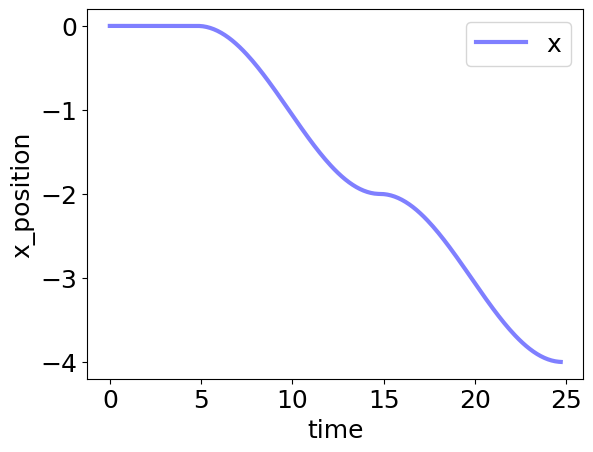

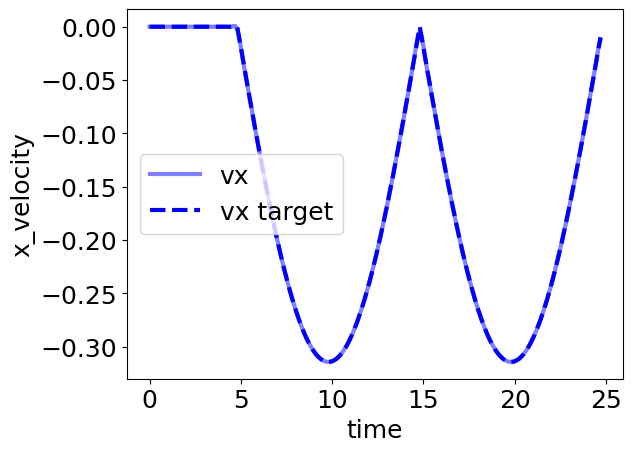

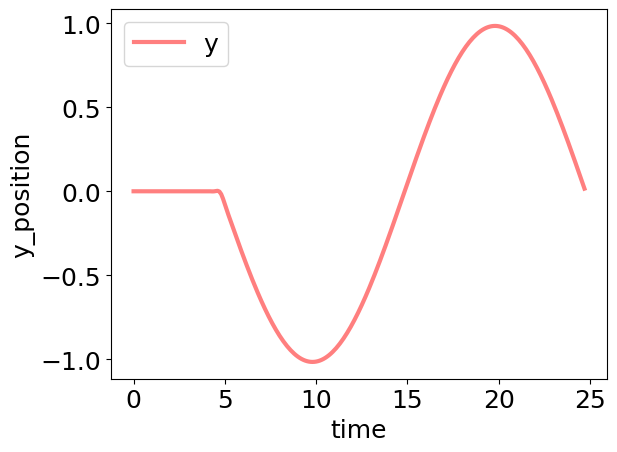

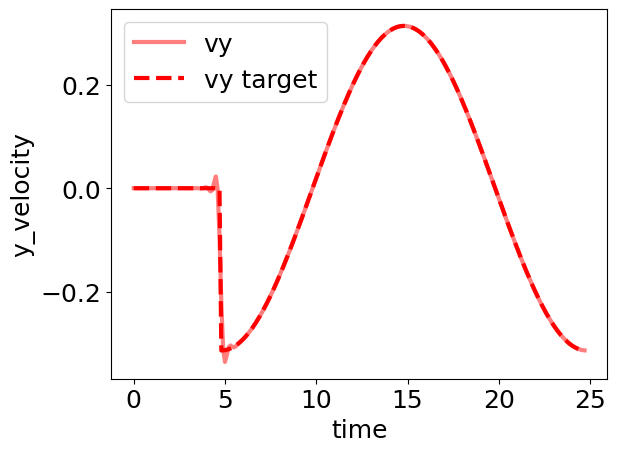

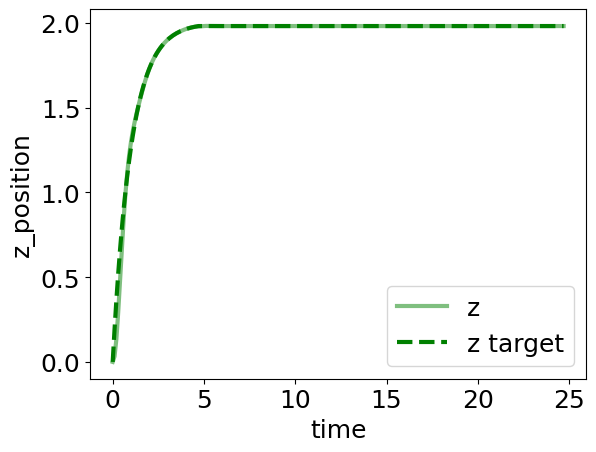

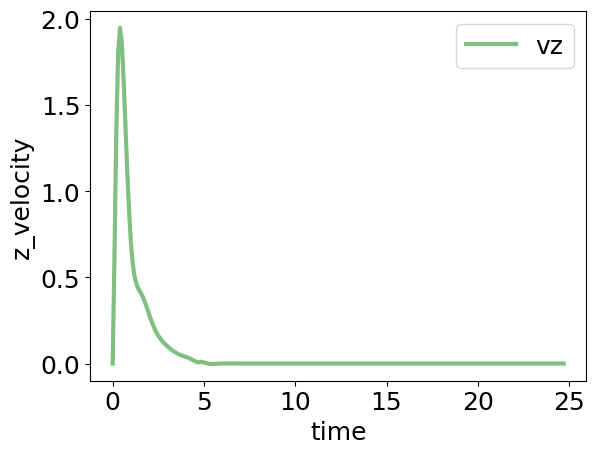

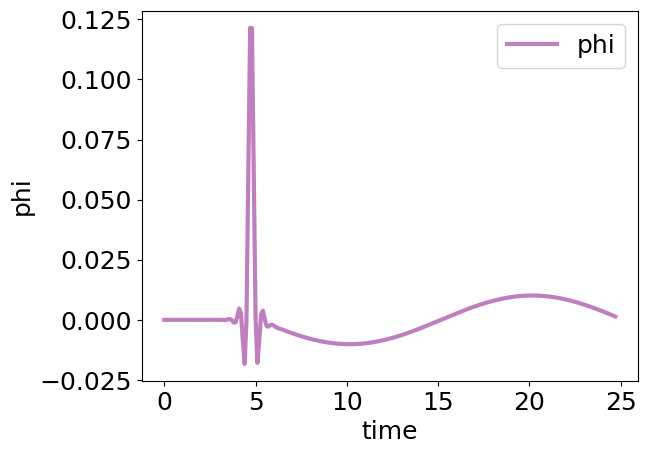

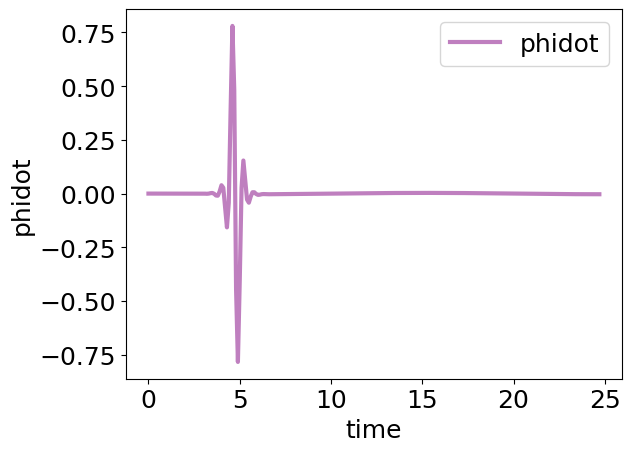

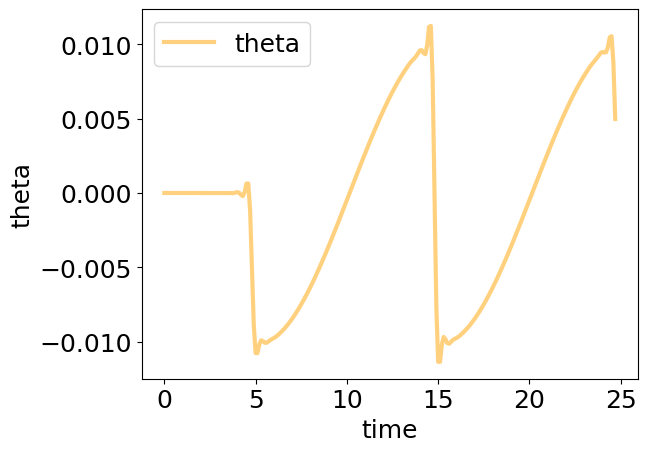

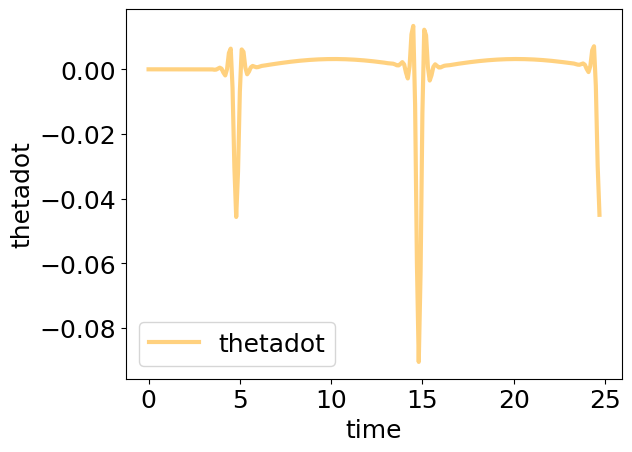

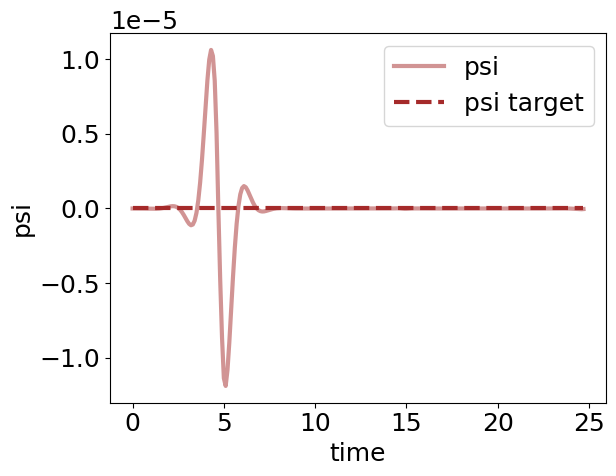

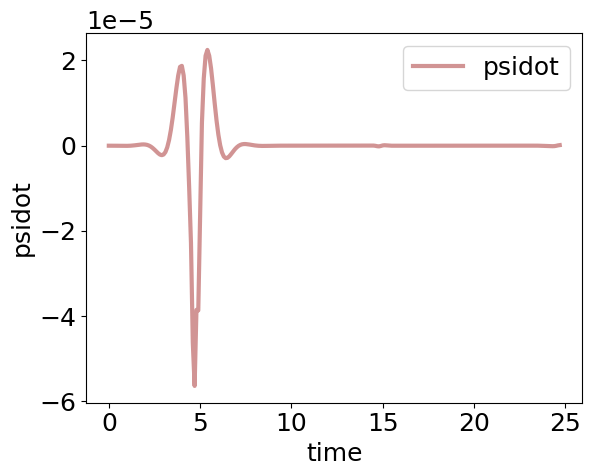

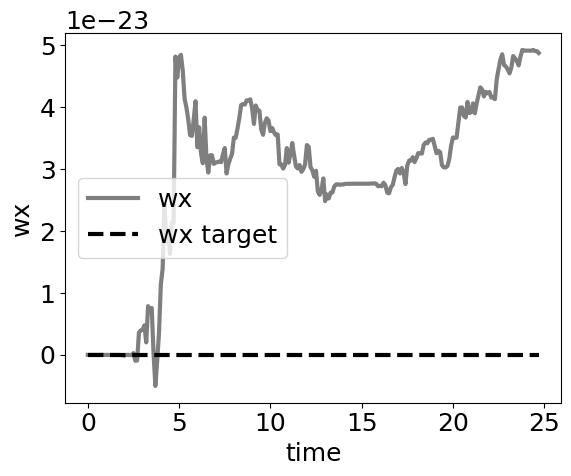

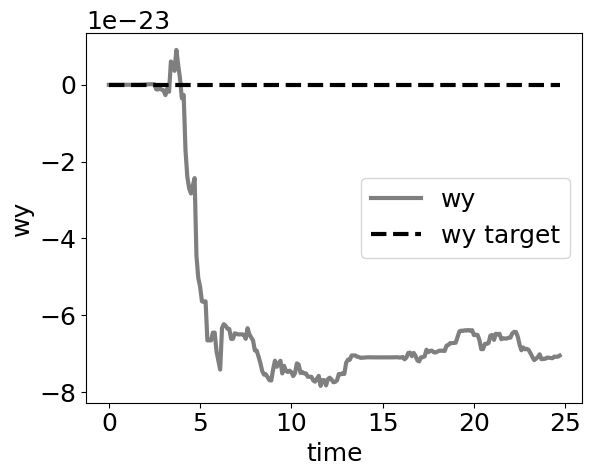

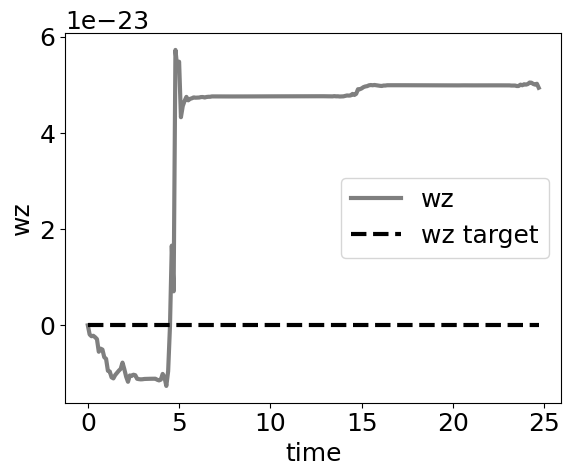

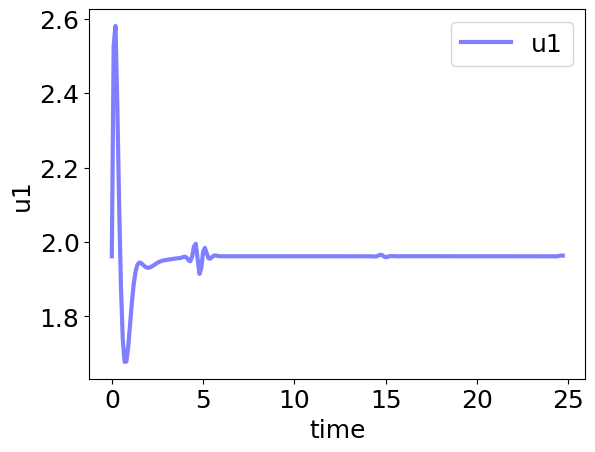

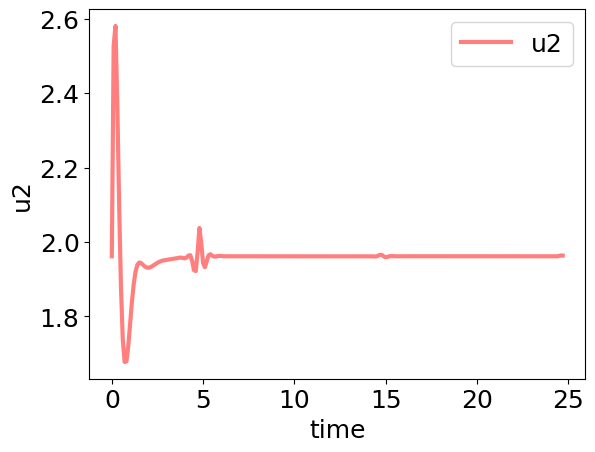

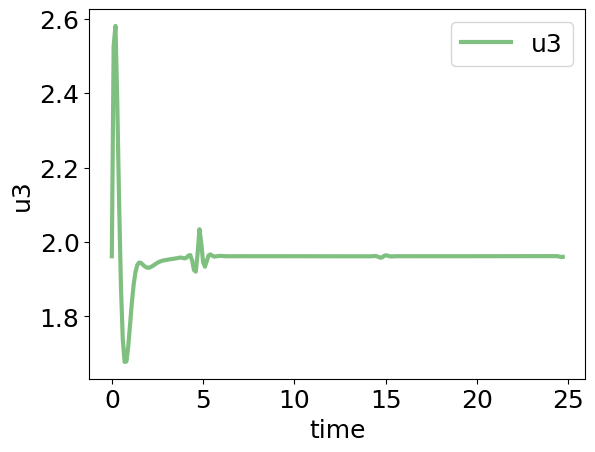

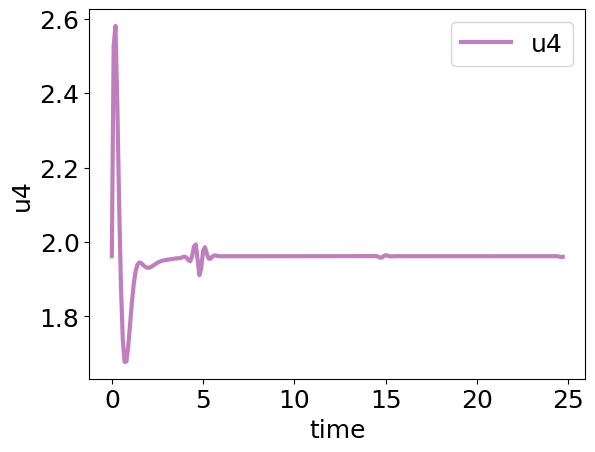

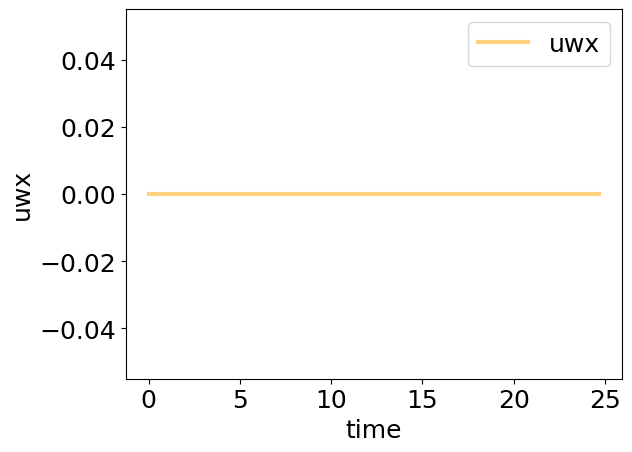

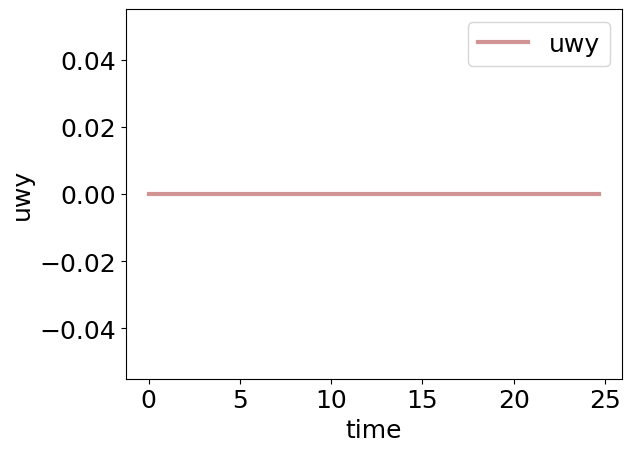

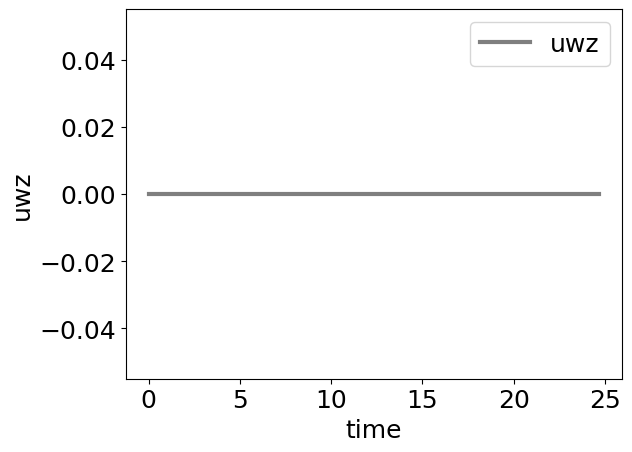

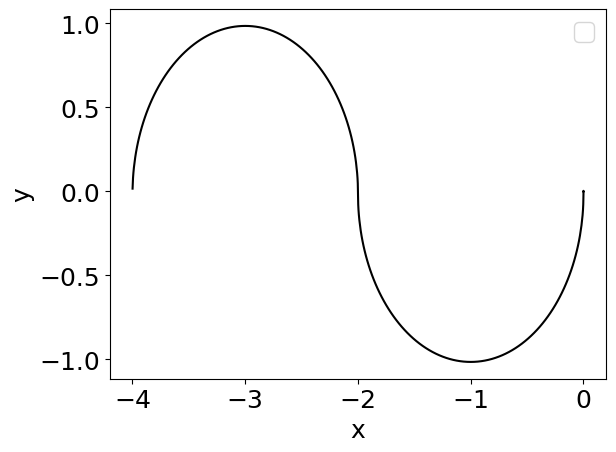

<Figure size 640x480 with 0 Axes>

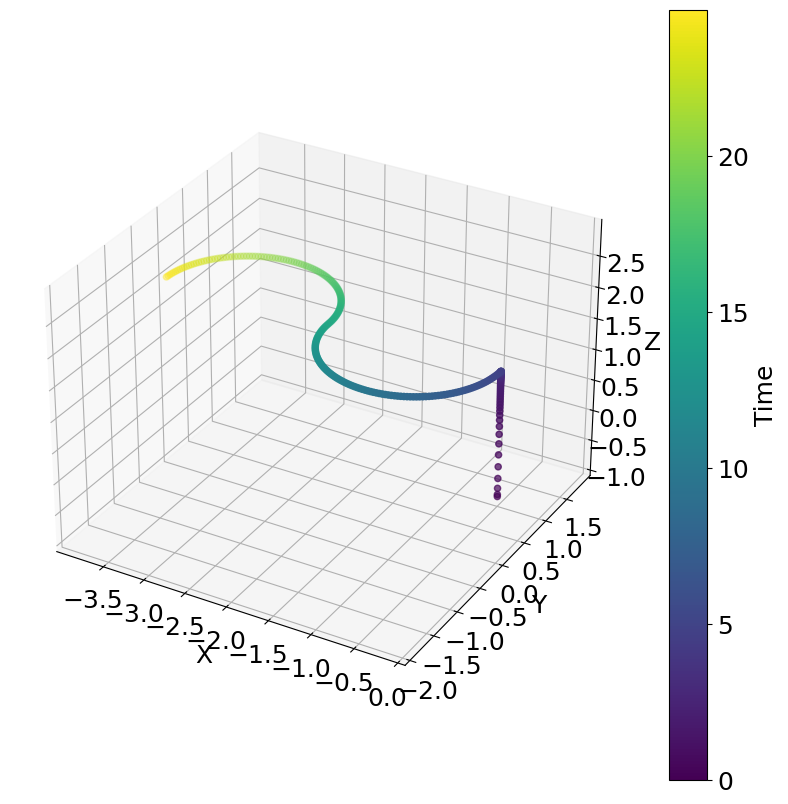

In [103]:
mpc.plot_states_targets_inputs()

# Get measuerments by just running the simulator
## [Px,Vx,Py,Vy,Pz,Vz, ... 
## R,dR,P,dP,Yaw,dYaw, ... 
## Wx,Wy,Wz,OFx,OFy,OFz,Ax,Ay,Az,acc_x,acc_y,acc_z]

In [104]:
M=mpc.run_just_simulator(M=['dR','dP','dYaw','OFx','OFy','OFz','Ax','Ay','Az','acc_x','acc_y','acc_z'])

/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py:477: RuntimeWarning: invalid value encountered in divide
  measurements[:, 15] = np.where(self.xsim[:, 4] != 0, self.xsim[:, 1] / self.xsim[:, 4], 0.0)  # OFx = Vx / Pz
/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py:478: RuntimeWarning: invalid value encountered in divide
  measurements[:, 16] = np.where(self.xsim[:, 4] != 0, self.xsim[:, 3] / self.xsim[:, 4], 0.0)  # OFy = Vy / Pz
/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py:479: RuntimeWarning: invalid value encountered in divide
  measurements[:, 17] = np.where(self.xsim[:, 4] != 0, self.xsim[:, 5] / self.xsim[:, 4], 0.0)  # OFz = Vz / Pz


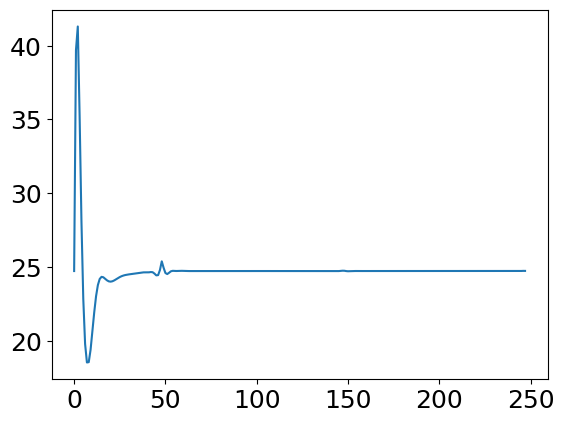

In [105]:
XXX,UUU=mpc.get_X_and_U()
# print(UUU.T[0])

U1=(UUU.T[0]**2+UUU.T[1]**2+UUU.T[2]**2+UUU.T[3])*Real_b

plt.plot(U1)

# Adding noise to the data for simulation 

In [79]:
# Noise for measurements:
v=[.01,    # x
   .01,    # vx
   .01,    # y
   .01,    # vy
   .01,    # z
   .01,    # vz
   0.01,   # phi
   0.001,  # dphi
   0.01,   # theta
   0.001,  # dtheta
   0.01,   # psi
   0.001,   # dpsi
   0.01,   # wx
   0.01,   # wy
   0.01   # wz 
   ]
v=np.multiply(v,1)
# print('v:',v)
# add noise to X_MPC
X_MPC_noisy = copy.deepcopy(X_MPC).T
# print('X_MPC_noisy:',X_MPC_noisy[0,:])
for i in range(12):
    X_MPC_noisy[i] = X_MPC_noisy[i] + np.random.normal(0,v[i],T_length)

# print('X_MPC_noisy:',X_MPC_noisy[0])
U=U_MPC.T[0:4]
# print('X_MPC_noisy:',X_MPC_noisy.shape)
# print('U_MPC:',U_MPC.shape)
plt.figure(figsize=(20,10))
plt.plot(t,X_MPC_noisy[3],label='vy_noisy')
plt.plot(t,X_MPC.T[3],label='vy')
# plt.xlim([start,stop])
plt.xlim([0,10])
plt.legend()

ValueError: operands could not be broadcast together with shapes (348,) (40,) 

In [186]:
def replace_outliers(data, threshold=1.5):
    """
    Replace outliers in a numpy array with the average of their neighboring values using the IQR method.
    
    Parameters:
    data (numpy array): The input data array.
    threshold (float): The IQR threshold to use for outlier detection. Default is 1.5.
    
    Returns:
    numpy array: The array with outliers replaced by the average of their neighboring values.
    """
    data = data.copy()  # To avoid modifying the original data
    
    # Calculate the first (Q1) and third (Q3) quartiles
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Determine the outlier bounds
    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)
    
    # Find indices of outliers
    outliers_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
    
    for idx in outliers_indices:
        if idx == 0:
            # If the outlier is at the start, use the next value
            data[idx] = data[idx + 1]
        elif idx == len(data) - 1:
            # If the outlier is at the end, use the previous value
            data[idx] = data[idx - 1]
        else:
            # Replace the outlier with the average of its neighbors
            data[idx] = (data[idx - 1] + data[idx + 1]) / 2
    
    return data

# Extended Kalman Filter

Note: this EKF function expects everything to be given as 2D arrays.

In [59]:
# import ekf

In [87]:
def f_d(X, U):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)
    
    # Extract control inputs
    u1, u2, u3, u4 = np.ravel(U)
    
    # Compute intermediate variables
    U1 = b * (u1**2 + u2**2 + u3**2 + u4**2)
    U2 = b * (u4**2 + u1**2 - u2**2 - u3**2)
    U3 = b * (u3**2 + u4**2 - u1**2 - u2**2)
    U4 = d * (-u1**2 + u2**2 - u3**2 + u4**2)
    Omega = u2 + u4 - u1 - u3

    # define drag dynamics
    vrx = vx - wx
    vry = vy - wy
    vrz = vz - wz
    
    new_x=x + vx * dt
    new_vx = (1/m) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Dl * vrx / m) * dt
    new_y = y + vy * dt
    new_vy = (1/m) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Dl * vry / m) * dt
    new_z = z + vz * dt
    new_vz = (1/m) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Dl * vrz / m) * dt
    new_phi = phi + dphi * dt
    new_dphi = dtheta * dpsi * (Iy - Iz) / Ix - (Jr * dtheta * Omega / Ix) + (U2 * l / Ix) - (Dr * dphi / Ix) * dt
    new_theta = theta + dtheta * dt
    new_dtheta = dphi * dpsi * (Iz - Ix) / Iy + (Jr * dphi * Omega / Iy) + (U3 * l / Iy) - (Dr * dtheta / Iy) * dt
    new_psi = psi + dpsi * dt
    new_dpsi = dphi * dtheta * (Ix - Iy) / Iz + (U4 / Iz) - (Dr * dpsi / Iz) * dt
    new_wx = wx
    new_wy = wy
    new_wz = wz
    
    new_X = np.atleast_2d(np.array([new_x, new_vx, new_y, new_vy, new_z, new_vz, new_phi, new_dphi, new_theta, new_dtheta, new_psi, new_dpsi,new_wx,new_wy,new_wz])).T

    return new_X

# write function as a continuous time function
def f_c(X, U):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)
    
    # Extract control inputs
    u1, u2, u3, u4 = np.ravel(U)
    
    # Compute intermediate variables
    U1 = b * (u1**2 + u2**2 + u3**2 + u4**2)
    U2 = b * (u4**2 + u1**2 - u2**2 - u3**2)
    U3 = b * (u3**2 + u4**2 - u1**2 - u2**2)
    U4 = d * (-u1**2 + u2**2 - u3**2 + u4**2)
    Omega = u2 + u4 - u1 - u3

    # define drag dynamics
    vrx = vx - wx
    vry = vy - wy
    vrz = vz - wz
    
    dxdt=vx
    dvxdt = (1/m) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Dl * vrx / m)
    dydt=vy
    dvydt = (1/m) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Dl * vry / m)
    dzdt=vz
    dvzdt = (1/m) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Dl * vrz / m)
    dphidt=dphi
    ddphidt = dtheta * dpsi * (Iy - Iz) / Ix - (Jr * dtheta * Omega / Ix) + (U2 * l / Ix) - (Dr * dphi / Ix)
    dthetadt= dtheta
    ddthetadt = dphi * dpsi * (Iz - Ix) / Iy + (Jr * dphi * Omega / Iy) + (U3 * l / Iy) - (Dr * dtheta / Iy)
    dpsidt= dpsi
    ddpsidt = dphi * dtheta * (Ix - Iy) / Iz + (U4 / Iz) - (Dr * dpsi / Iz)
    dwx = 0
    dwy = 0
    dwz = 0
    

    new_X= scipy.integrate.odeint(lambda X, t: [dxdt, dvxdt, dydt, dvydt, dzdt, dvzdt, dphidt, ddphidt, dthetadt, ddthetadt, dpsidt, ddpsidt, dwx, dwy, dwz], np.ravel(X), [0, dt])[-1]
    new_X = np.atleast_2d(new_X).T
    return new_X

def h_d(X,U):
    # Extract the states
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)

    Px   = x
    Vx   = vx
    Py   = y
    Vy   = vy
    Pz   = z
    Vz   = vz
    R    = phi
    dR   = dphi
    P    = theta
    dP   = dtheta
    Yaw  = psi
    dYaw = dpsi
    Wx   = wx
    Wy   = wy
    Wz   = wz
    OFx  = vx/z
    OFy  = vy/z
    OFz  = vz/z
    Ax   = vx-wx
    Ay   = vy-wy
    Az   = vz-wz

    # Create clusters
    P_cluster = np.array([Px, Py, Pz])
    V_cluster = np.array([Vx, Vy, Vz])
    Attitude_cluster = np.array([R, P, Yaw])
    dAttitude_cluster = np.array([dR, dP, dYaw])
    W_cluster = np.array([Wx, Wy, Wz])
    OF_cluster = np.array([OFx, OFy, OFz])
    A_cluster = np.array([Ax, Ay, Az])

    # Y=np.vstack((P_cluster, V_cluster, Attitude_cluster, dAttitude_cluster, W_cluster, OF_cluster, A_cluster))
    Y=np.atleast_2d(np.hstack((dAttitude_cluster, OF_cluster, A_cluster))).T

    # Y = np.concatenate((P_cluster, V_cluster, Attitude_cluster, dAttitude_cluster, W_cluster, OF_cluster, A_cluster))
    # Only return the measured states
    # Y=np.atleast_2d(np.array([Vx, Vy, Vz, dR, dP, dYaw, Wx, Wy, Wz])).T
    return Y

# Define Ynoisy
Ynoisy = copy.deepcopy(X_MPC_noisy)
# creat noisy measurements clusters
PM_cluster = np.array([Ynoisy[0], Ynoisy[2], Ynoisy[4]])
VM_cluster = np.array([Ynoisy[1], Ynoisy[3], Ynoisy[5]])
AttitudeM_cluster = np.array([Ynoisy[6], Ynoisy[8], Ynoisy[10]])
dAttitudeM_cluster = np.array([Ynoisy[7], Ynoisy[9], Ynoisy[11]])
WM_cluster = np.array([Ynoisy[12], Ynoisy[13], Ynoisy[14]])
OFM_cluster = np.array([Ynoisy[1]/Ynoisy[4], Ynoisy[3]/Ynoisy[4], Ynoisy[5]/Ynoisy[4]])
AM_cluster = np.array([Ynoisy[1]-Ynoisy[12], Ynoisy[3]-Ynoisy[13], Ynoisy[5]-Ynoisy[14]])

# Ynoise_small = 
# Ynoisy_small = np.vstack((PM_cluster, VM_cluster, AttitudeM_cluster, dAttitudeM_cluster, WM_cluster, OFM_cluster, AM_cluster))
Ynoisy_small = np.vstack((dAttitudeM_cluster,OFM_cluster, AM_cluster))

# Ynoisy_small = Ynoisy[[1,3,5,7,8,9,12,13,14],:]
# Ynoisy_small = np.atleast_2d([replace_outliers(np.divide(Ynoisy[1],Ynoisy[4])),replace_outliers(np.divide(Ynoisy[3],Ynoisy[4])),replace_outliers(np.divide(Ynoisy[5],Ynoisy[4])),Ynoisy[6],Ynoisy[8],Ynoisy[10],Ynoisy[12],Ynoisy[13],Ynoisy[14]])
# print('Ynoisy_small:',Ynoisy_small[0])

# Define the initial state estimate
# x0 = np.atleast_2d(X_MPC_noisy.T[0]).T
x0=np.atleast_2d(np.array([0.0,vx[0]+1,0.0,vy[0]+1,z[0],vz[0],0.0,0.0,0.0,0.0,psi[0],0.0,wx[0]+1,wy[0]+1,wz[0]])).T

# Define the process noise covariance matrix
Q = np.diag(np.array([0.0, 0.01, 0.0, 0.01, 0.0, 0.01, 0.0, 0.01, 0.0, 0.01, 0.0, 0.01, 0.01, 0.01, 0.01]))**2

# define the measurement noise covariance matrix based on clusters
PV_cluster = np.array([v[0], v[2], v[4]])
VV_cluster = np.array([v[1], v[3], v[5]])
AttitudeV_cluster = np.array([v[6], v[8], v[10]])
dAttitudeV_cluster = np.array([v[7], v[9], v[11]])
WV_cluster = np.array([v[12], v[13], v[14]])
OFV_cluster = np.array([.01, .01, .01])
AV_cluster = np.array([.01,.01,.01])


v_small = np.hstack([dAttitudeV_cluster,OFV_cluster,AV_cluster])
R = np.power(np.diag(v_small),2)
P0 = np.diag(np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1]))**2


# check that all inputs are a two-dimensional array

* Y (number of measuerment states, length of time series)
* X0 (number of states, 1)
* U (number of inputs, length of time series)
* Q (number of states, number of states)
* R (number of measuerment states, number of measuerment states)
* P (number of states, number of states)

In [146]:
# check that all inputs are a two-dimensional array
print("X_MPC_noisy:",X_MPC_noisy.shape) 
print('Ynoisy_small:',Ynoisy_small.shape)
print('x0:',x0.shape)
print('U:',U.shape)
print('Q:',Q.shape)
print('R:',R.shape)
print('P0:',P0.shape)
print('v_small:',v_small)


X_MPC_noisy: (15, 128)


NameError: name 'Ynoisy_small' is not defined

In [89]:
xhat, P, s = EKF.ekf(Ynoisy_small, x0, f_c, h_d, Q, R, U, P0)

In [90]:
x_hat=xhat[0,:] # x estimate
vx_hat=xhat[1,:] # vx estimate
y_hat=xhat[2,:] # y estimate
vy_hat=xhat[3,:] # vy estimate
z_hat=xhat[4,:] # z estimate
vz_hat=xhat[5,:] # vz estimate
phi_hat=xhat[6,:] # phi estimate
dphi_hat=xhat[7,:] # dphi estimate
theta_hat=xhat[8,:] # theta estimate
dtheta_hat=xhat[9,:] # dtheta estimate
psi_hat=xhat[10,:] # psi estimate
dpsi_hat=xhat[11,:] # dpsi estimate
wx_hat=xhat[12,:] # wx estimate
wy_hat=xhat[13,:] # wy estimate
wz_hat=xhat[14,:] # wz estimate


In [95]:
# save the estimated states to a csv file with headers to sub directory of current directory called estimation_data

estimated_states = np.vstack((x_hat,vx_hat,y_hat,vy_hat,z_hat,vz_hat,phi_hat,dphi_hat,theta_hat,dtheta_hat,psi_hat,dpsi_hat,wx_hat,wy_hat,wz_hat)).T
np.savetxt('estimation_data/estimated_states.csv', estimated_states, delimiter=',', header='x,vx,y,vy,z,vz,phi,dphi,theta,dtheta,psi,dpsi,wx,wy,wz', comments='')

# plotting truth, measuerment, and estimation

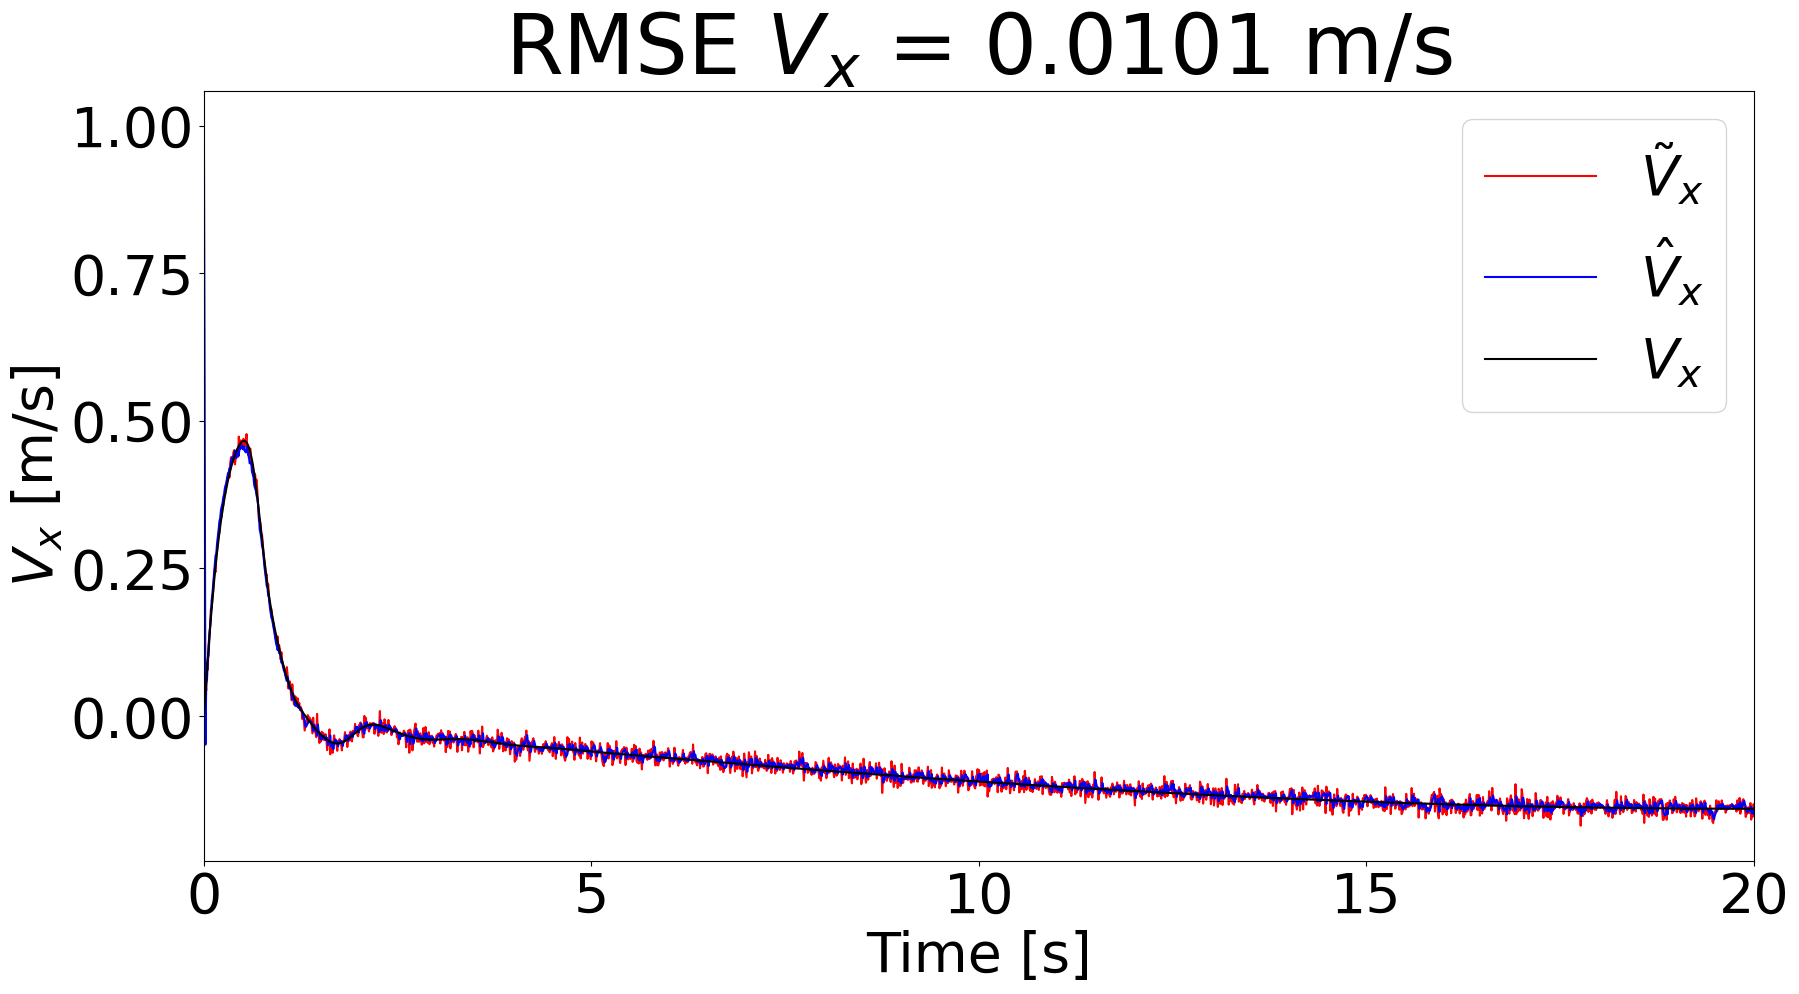

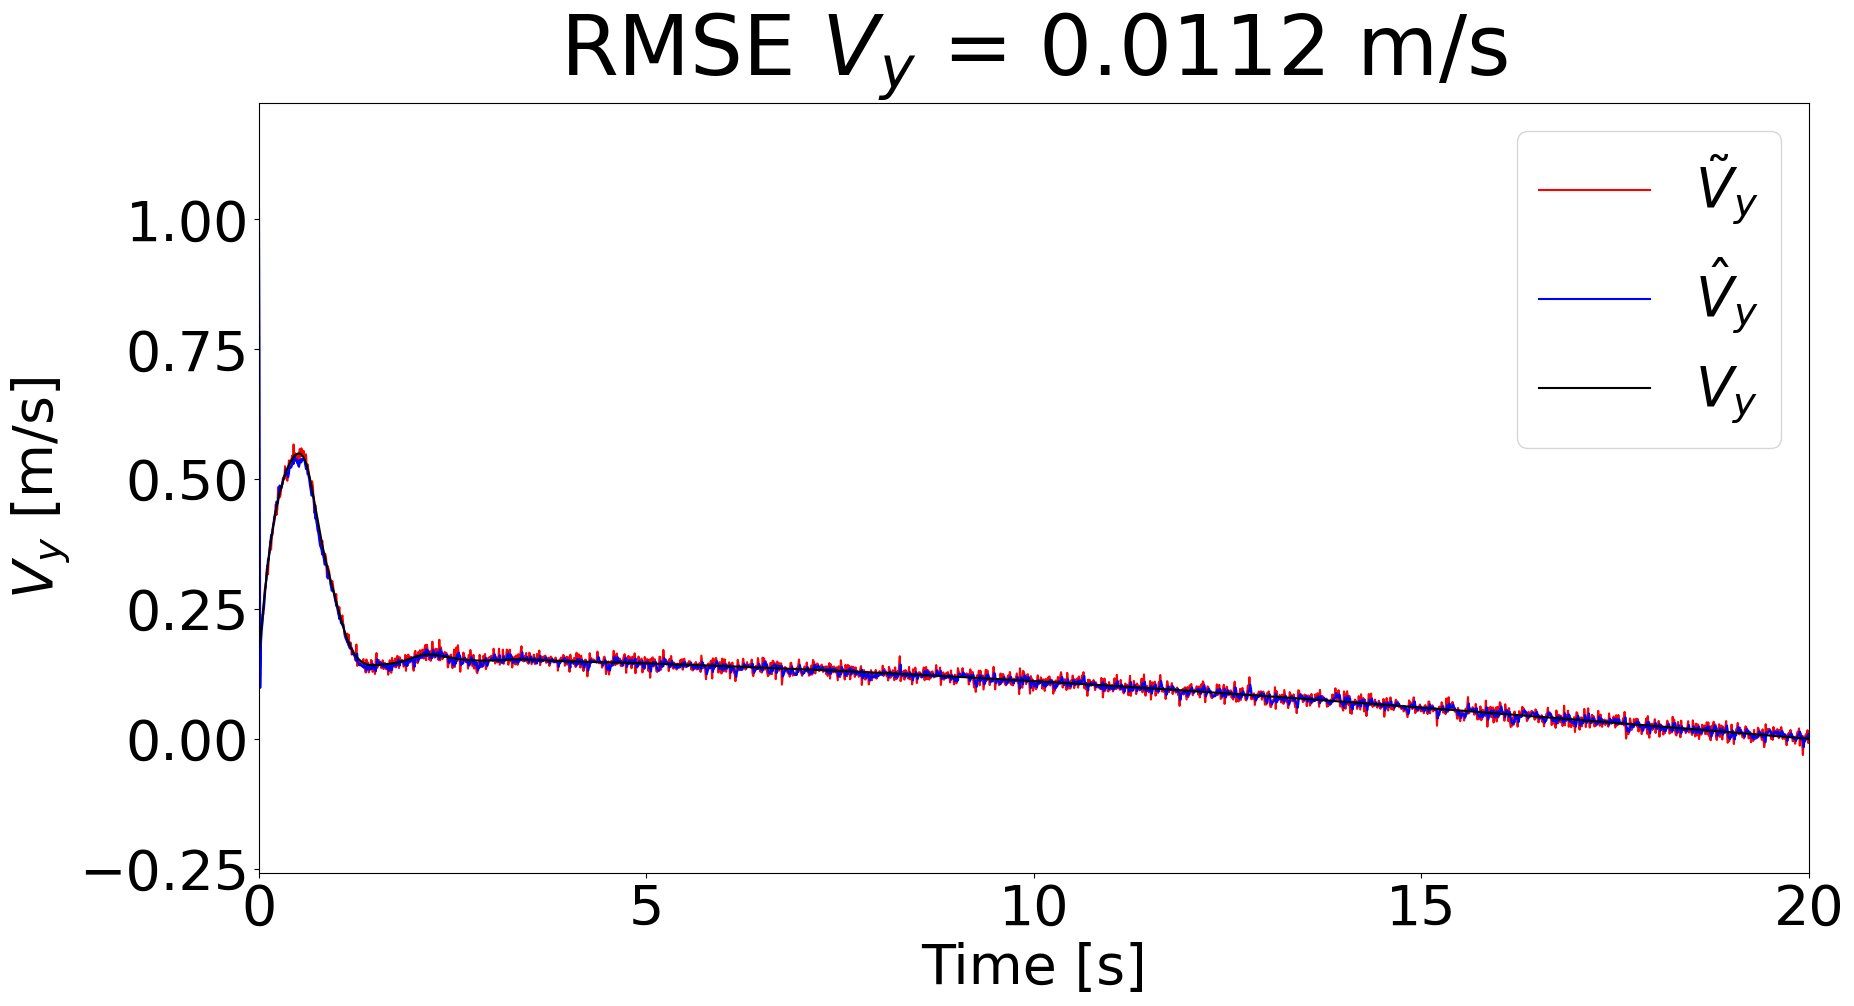

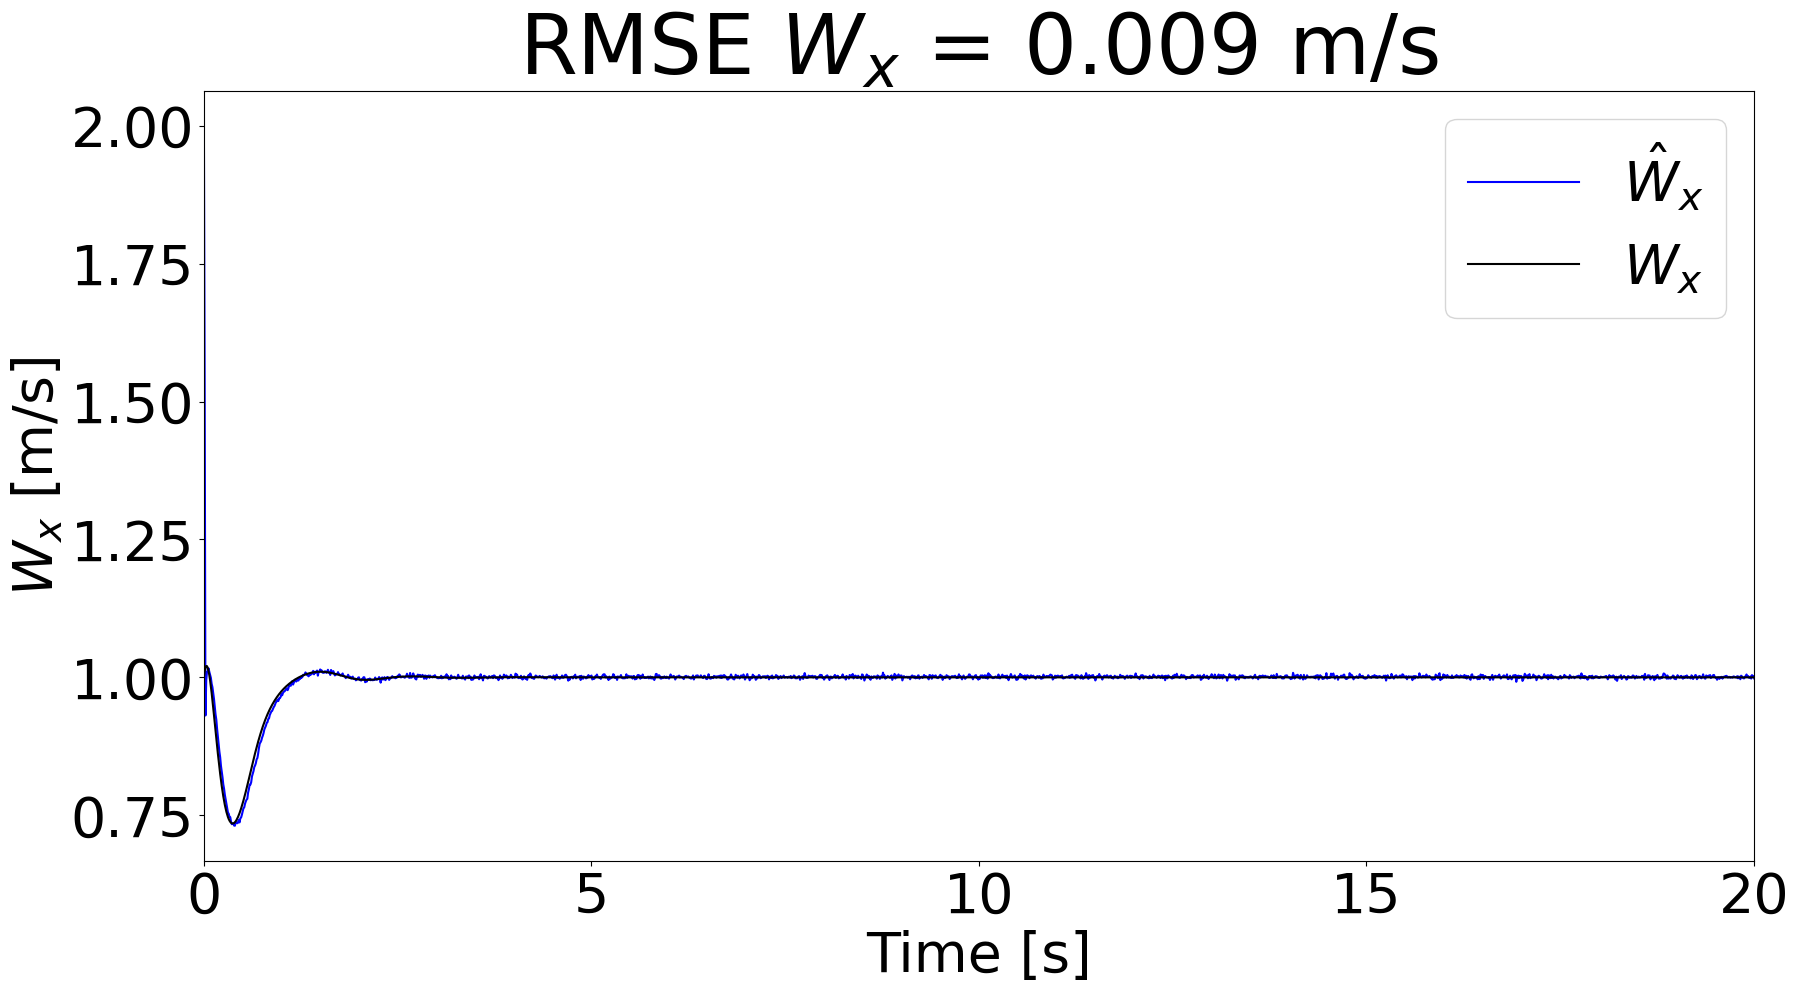

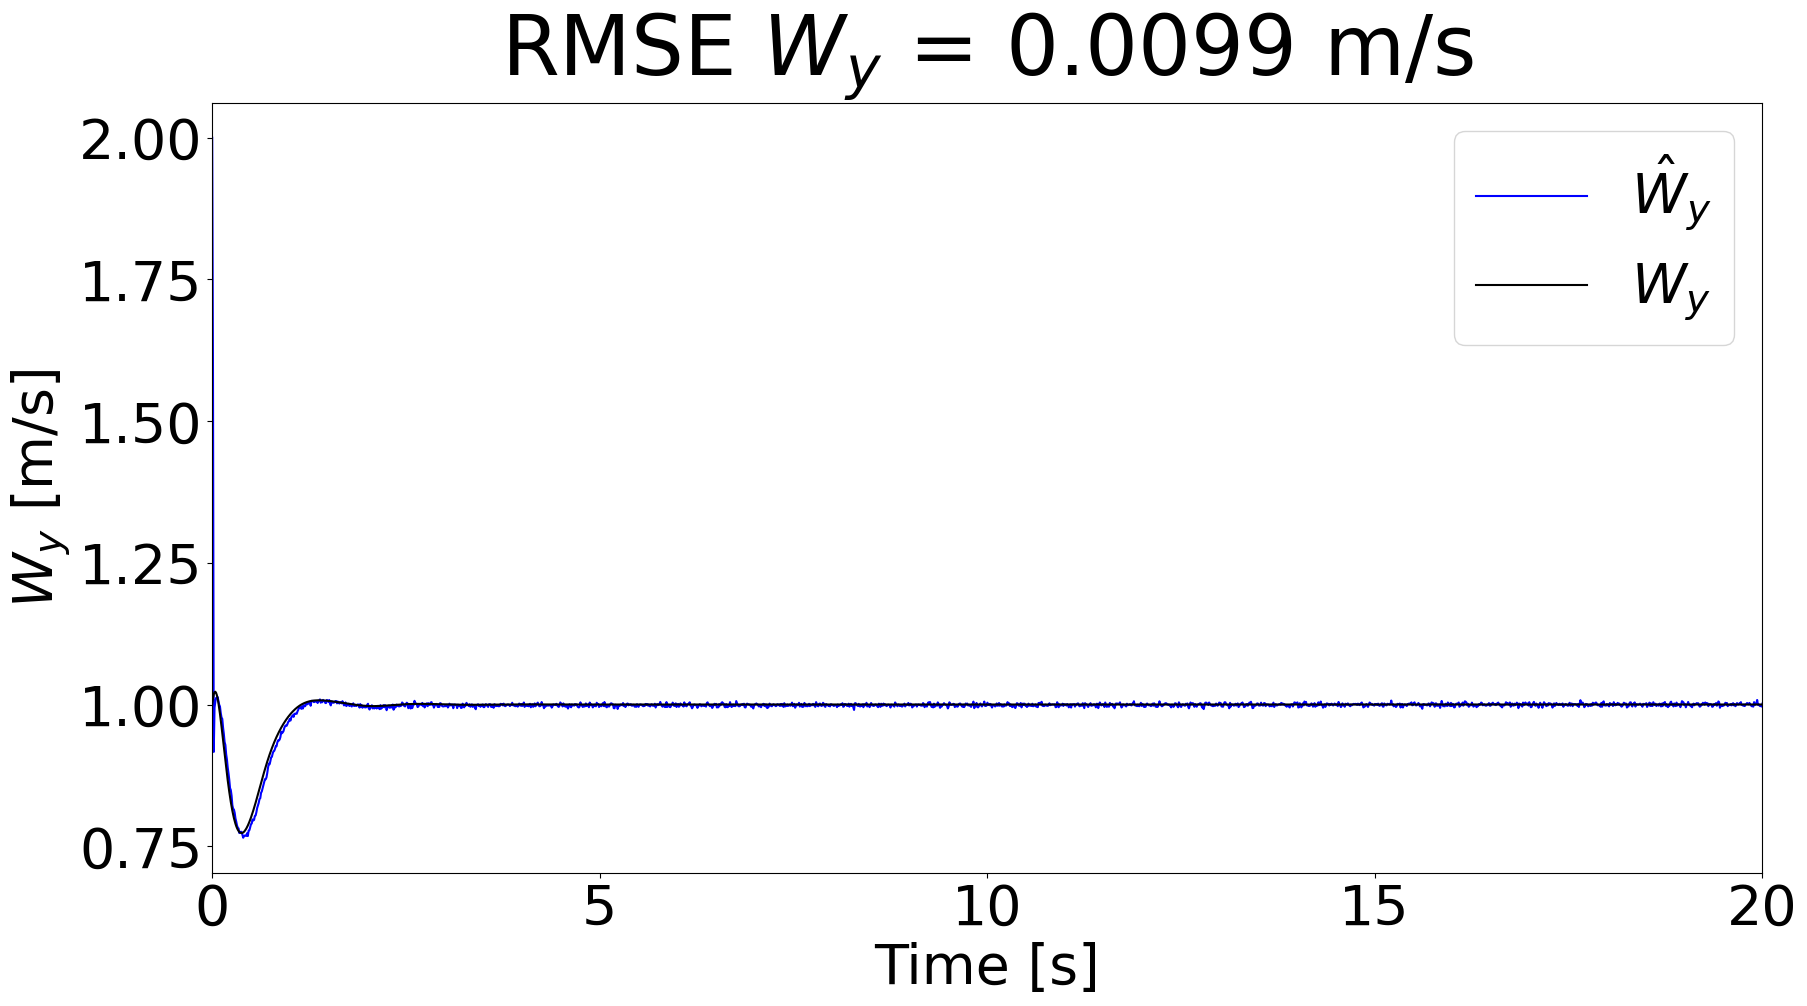

In [91]:
start=0
stop=20

plt.rcParams.update({
    'legend.fontsize': 40,
    'axes.labelsize': 40,
    'axes.titlesize': 60,
    'xtick.labelsize': 40,
    'ytick.labelsize': 40
})
# plt.figure(figsize=(20,10))
# plt.plot(t,x_hat,label='x_hat',color='blue')
# plt.plot(t,X_MPC_noisy[0],label='x_measuer',color='red')
# plt.plot(t,X_MPC.T[0],label='x',color='black',alpha=1)
# plt.xlim([start,stop])
# RMSE_X = np.sqrt(np.mean((x_hat-X_MPC.T[0])**2))
# plt.title('RMSE_X: '+str(np.round(RMSE_X,4))+ ' m')
# plt.legend()

plt.figure(figsize=(20,10))

plt.plot(t,X_MPC_noisy[1],label='$\\tilde{V}_{x}$',color='red')
plt.plot(t,vx_hat,label='$\hat{V}_{x}$',color='blue')
plt.plot(t,X_MPC.T[1],label='$V_{x}$',color='black',alpha=1)
plt.xlim([start,stop])
# plt.xlim([0,1])
plt.xticks([0, 5, 10, 15, 20])
plt.xlabel('Time [s]')
plt.ylabel('$V_{x}$ [m/s]')
# plt.ylim([.75,1.25])
RMSE_VX = np.sqrt(np.mean((vx_hat[1:]-X_MPC.T[1][1:])**2))
plt.title('RMSE ${V}_{x}$ = '+str(np.round(RMSE_VX,4))+ ' m/s')

plt.legend()


# plt.figure(figsize=(20,10))
# plt.plot(t,y_hat,label='y_hat',color='blue')
# plt.plot(t,X_MPC_noisy[2],label='y_measuer',color='red')
# plt.plot(t,X_MPC.T[2],label='y',color='black',alpha=1)
# plt.xlim([start,stop])
# RMSE_Y = np.sqrt(np.mean((y_hat-X_MPC.T[2])**2))
# plt.title('RMSE_Y: '+str(np.round(RMSE_Y,4))+ ' m')
# plt.legend()

plt.figure(figsize=(20,10))

plt.plot(t,X_MPC_noisy[3],label='$\\tilde{V}_{y}$',color='red')
plt.plot(t,vy_hat,label='$\hat{V}_{y}$',color='blue')
plt.plot(t,X_MPC.T[3],label='${V}_{y}$',color='black',alpha=1)
plt.xlim([start,stop])
# plt.xlim([0,1])
plt.xticks([0, 5, 10, 15, 20])
plt.xlabel('Time [s]')
plt.ylabel('$V_{y}$ [m/s]')
RMSE_VY = np.sqrt(np.mean((vy_hat[1:]-X_MPC.T[3][1:])**2))
plt.title('RMSE ${V}_{y}$ = '+str(np.round(RMSE_VY,4))+ ' m/s')
plt.legend()

# plt.figure(figsize=(20,10))
# plt.plot(t,z_hat,label='z_hat',color='blue')
# plt.plot(t,X_MPC_noisy[4],label='z_measuer',color='red')
# plt.plot(t,X_MPC.T[4],label='z',color='black',alpha=1)
# plt.xlim([start,stop])
# RMSE_Z = np.sqrt(np.mean((z_hat-X_MPC.T[4])**2))
# plt.title('RMSE_Z: '+str(np.round(RMSE_Z,4))+ ' m')
# plt.legend()

# plt.figure(figsize=(20,10))
# plt.plot(t,vz_hat,label='vz_hat',color='blue')
# plt.plot(t,X_MPC_noisy[5],label='vz_measuer',color='red')
# plt.plot(t,X_MPC.T[5],label='vz',color='black',alpha=1)
# plt.xlim([start,stop])
# RMSE_VZ = np.sqrt(np.mean((vz_hat-X_MPC.T[5])**2))
# plt.title('RMSE_VZ: '+str(np.round(RMSE_VZ,4))+ ' m/s')
# plt.legend()

# plt.figure(figsize=(20,10))
# plt.plot(t,phi_hat,label='phi_hat',color='blue')
# plt.plot(t,X_MPC_noisy[6],label='phi_measuer',color='red')
# plt.plot(t,X_MPC.T[6],label='phi',color='black',alpha=1)
# plt.xlim([start,stop])
# RMSE_PHI = np.sqrt(np.mean((phi_hat-X_MPC.T[6])**2))
# plt.title('RMSE_PHI: '+str(np.round(RMSE_PHI,4))+ ' rad')
# plt.legend()

# plt.figure(figsize=(20,10))
# plt.plot(t,dphi_hat,label='dphi_hat',color='blue')
# plt.plot(t,X_MPC_noisy[7],label='dphi_measuer',color='red')
# plt.plot(t,X_MPC.T[7],label='dphi',color='black',alpha=1)
# plt.xlim([start,stop])
# RMSE_DPHI = np.sqrt(np.mean((dphi_hat-X_MPC.T[7])**2))
# plt.title('RMSE_DPHI: '+str(np.round(RMSE_DPHI,4))+ ' rad/s')
# plt.legend()

# plt.figure(figsize=(20,10))
# plt.plot(t,theta_hat,label='theta_hat',color='blue')
# plt.plot(t,X_MPC_noisy[8],label='theta_measuer',color='red')
# plt.plot(t,X_MPC.T[8],label='theta',color='black',alpha=1)
# plt.xlim([start,stop])
# RMSE_THETA = np.sqrt(np.mean((theta_hat-X_MPC.T[8])**2))
# plt.title('RMSE_THETA: '+str(np.round(RMSE_THETA,4))+ ' rad')
# plt.legend()

# plt.figure(figsize=(20,10))
# plt.plot(t,dtheta_hat,label='dtheta_hat',color='blue')
# plt.plot(t,X_MPC_noisy[9],label='dtheta_measuer',color='red')
# plt.plot(t,X_MPC.T[9],label='dtheta',color='black',alpha=1)
# plt.xlim([start,stop])
# RMSE_DTHETA = np.sqrt(np.mean((dtheta_hat-X_MPC.T[9])**2))
# plt.title('RMSE_DTHETA: '+str(np.round(RMSE_DTHETA,4))+ ' rad/s')
# plt.legend()

# plt.figure(figsize=(20,10))
# plt.plot(t,psi_hat,label='psi_hat',color='blue')
# plt.plot(t,X_MPC_noisy[10],label='psi_measuer',color='red')
# plt.plot(t,X_MPC.T[10],label='psi',color='black',alpha=1)
# plt.xlim([start,stop])
# RMSE_PSI = np.sqrt(np.mean((psi_hat-X_MPC.T[10])**2))
# plt.title('RMSE_PSI: '+str(np.round(RMSE_PSI,4))+ ' rad')
# plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,wx_hat,label='$\hat{W}_{x}$',color='blue')
# plt.plot(t,X_MPC_noisy[12],label='wx_measuer',color='red')
plt.plot(t,X_MPC.T[12],label='${W}_{x}$',color='black',alpha=1)
plt.xlim([start,stop])
plt.xticks([0, 5, 10, 15, 20])
plt.xlabel('Time [s]')
plt.ylabel('${W}_{x}$ [m/s]')
RMSE_WX = np.sqrt(np.mean((wx_hat[1:]-X_MPC.T[12][1:])**2))
plt.title('RMSE ${W}_{x}$ = '+str(np.round(RMSE_WX,4))+ ' m/s')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,wy_hat,label='$\hat{W}_{y}$',color='blue')
# plt.plot(t,X_MPC_noisy[13],label='$\\tilde{W}_{y}$',color='red')
plt.plot(t,X_MPC.T[13],label='${W}_{y}$',color='black',alpha=1)
plt.xlim([start,stop])
plt.xticks([0, 5, 10, 15, 20])
plt.xlabel('Time [s]')
plt.ylabel('${W}_{y}$ [m/s]')
RMSE_WY = np.sqrt(np.mean((wy_hat[1:]-X_MPC.T[13][1:])**2))
plt.title('RMSE ${W}_{y}$ = '+str(np.round(RMSE_WY,4))+ ' m/s')
plt.legend()

# plt.figure(figsize=(20,10))
# plt.plot(t,wz_hat,label='$\hat{W}_{z}$',color='blue')
# # plt.plot(t,X_MPC_noisy[14],label='$\\tilde{W}_{z}$',color='red')
# plt.plot(t,X_MPC.T[14],label='${W}_{z}$',color='black',alpha=1)
# plt.xlim([start,stop])
# RMSE_WZ = np.sqrt(np.mean((wz_hat-X_MPC.T[14])**2))
# # plt.title('RMSE_WZ: '+str(np.round(RMSE_WZ,4))+ ' m/s')
# plt.legend()



In [92]:
# # 3d plot of where the drone actually is and where the drone thinks it is
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(vx_hat, vy_hat, vz_hat, label='Estimated Position',color='blue',alpha=1)
# ax.plot(X_MPC_noisy[1], X_MPC_noisy[3], X_MPC_noisy[5], label='Measured Position',color='red',alpha=1)
# ax.plot(X_MPC.T[1], X_MPC.T[3], X_MPC.T[5], label='Actual Position',color='black',alpha=1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# # ax.set_xlim([0,20])
# # ax.set_ylim([-10,1])
# # ax.set_zlim([-1,1])
# ax.legend()
# plt.show()
